# Classificação e Detecção de Doenças em Folhas
## **Pós-graduação em Ciência e Dados e Machine Learning**
## Trabalho Final - Deep Learning

**Disciplina:** Fundamentos de Deep Learning

**Professor:** André Juan Costa Vieira

**Nomes dos Integrantes:**

1 - Alexandre Teixeira de Oliveira - RA: 52400856

2 - Anderson Alves Coelho - RA: 52400560

3 - Daniela Martino dos Santos - RA:52400203

4 - Luísa Nascimento da Silva - RA: 52400752

5 - Viviane Amorim - RA: 52400197

# Descrição Geral do Trabalho

## Objetivo
Este notebook contém o projeto final executável em TensorFlow/Keras para **classificação e detecção de doenças em folhas** usando o dataset PlantVillage para Detecção de Objetos. Inclui instruções para download, pré-processamento com `tf.data`, modelo (EfficientNetB0), hyperparâmetros iniciais, callbacks e checklist de avaliação.

## Artigos-Base

**- Real-Time Plant Health Detection Using Deep Convolutional Neural Networks (Khalid et al., 2018)**: [link](https://www.researchgate.net/publication/368707047_Real-Time_Plant_Health_Detection_Using_Deep_Convolutional_Neural_Networks)

## Bases de dados

### PlantVillage Dataset

O conjunto de dados [Plant Village](https://www.kaggle.com/datasets/mohitsingh1804/plantvillage/data) é um conjunto de dados público com **54.305 imagens** de folhas de plantas doentes e saudáveis, coletadas em condições controladas (em laboratório).

As imagens abrangem 14 espécies de culturas, incluindo:
- Maçã
- Mirtilo
- Cereja
- Uva
- Laranja
- Pêssego
- Pimentão
- Batata
- Framboesa
- Soja
- Abóbora
- Morango
- Tomate

Contém também imagens de 17 doenças básicas, sendo 4 doenças bacterianas, 2 doenças causadas por mofo (oomiceto), 2 doenças virais e 1 doença causada por ácaro. 12 espécies de culturas também apresentam imagens de folhas saudáveis que não são visivelmente afetadas por doenças.

Para este projeto, estamos usando uma adaptação/aprimoramento do dataset original com anotações de bounding boxes para realização de detecção das regiões com doenças nas plantas. Essa versão se chama [PlantVillage for object detection YOLO](https://www.kaggle.com/datasets/sebastianpalaciob/plantvillage-for-object-detection-yolo/data).

### PlantDoc Dataset

## Construção e Arquitetura da Rede Neural


- Arquitetura CNN:

- Camadas utilizadas:

- Função de ativação:

- Técnicas de regularização:

- Métricas de avaliação:

# Importação de Bibliotecas

In [ ]:
import os
import cv2
import random
import shutil
import zipfile
import yaml

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Importação, visualização e preparação do dataset
Para carregar os dados, é preciso acessar a [pasta compartilhada](https://drive.google.com/drive/folders/1radfSTsYi8C4hO1FpfGh40DiFZkj8S-x?usp=drive_link)

In [ ]:
#Importando o dataset do Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Mostra o que tem no Meu Drive
print(os.listdir("/content/drive/MyDrive/PlantVillage/Datasets"))

['PlantVillage_ObjectDetection.zip']


In [ ]:
dataset_path = "/content/drive/MyDrive/PlantVillage/Datasets"

In [ ]:
print(os.listdir(dataset_path)[:10])

['PlantVillage_ObjectDetection.zip']


In [ ]:
base_dir = "/content/PlantVillage_ObjectDetection.zip"

In [ ]:
zip_path = "/content/drive/MyDrive/PlantVillage/Datasets/PlantVillage_ObjectDetection.zip"
extract_path = "/content/PlantVillage_OD"

In [ ]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
os.listdir(extract_path)

['PlantVillage_for_object_detection', 'val', 'train', 'test']

In [ ]:
#caminho do dataset descompactado
images_path = os.path.join(extract_path, "PlantVillage_for_object_detection", "Dataset", "images")
labels_path = os.path.join(extract_path, "PlantVillage_for_object_detection", "Dataset", "labels")
classes_file = os.path.join(extract_path, "PlantVillage_for_object_detection", "Dataset", "classes.yaml")

print("Total imagens:", len(os.listdir(images_path)))
print("Total labels:", len(os.listdir(labels_path)))
print("Total classes:", len(classes_file))

Total imagens: 54293
Total labels: 54293
Total classes: 79


In [ ]:
# Caminhos para os splits
train_img_dir = os.path.join(extract_path, "train/images")
val_img_dir   = os.path.join(extract_path, "val/images")
train_label_dir = os.path.join(extract_path, "train/labels")
val_label_dir   = os.path.join(extract_path, "val/labels")
test_img_dir = os.path.join(extract_path, "test/images")
test_label_dir = os.path.join(extract_path, "test/labels")

In [ ]:
# Criando array dos nomes das classes
with open(classes_file) as f:
    data = yaml.safe_load(f)

class_map = data['names']

In [ ]:
# Criar pastas caso não existam
for path in [train_img_dir, val_img_dir, train_label_dir, val_label_dir, test_img_dir, test_label_dir]:
    os.makedirs(path, exist_ok=True)

In [ ]:
# Listar e embaralhar as imagens
all_images = [f for f in os.listdir(images_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
random.shuffle(all_images)

In [ ]:
#Dividir treino e validação
split_ratio = 0.8  # 80% treino, 20% validação

In [ ]:
train_count = int(len(all_images) * split_ratio)

In [ ]:
train_images = all_images[:train_count]
val_images   = all_images[train_count:]

In [ ]:
#achar o label correspondente
def get_label_name(img_name):
    base = os.path.splitext(img_name)[0]  # nome do arquivo sem extensão
    return base + ".txt"  # adiciona extensão correta do label

In [ ]:
#Copiar arquivos para treino
for img_name in val_images:
    shutil.copy(os.path.join(images_path, img_name), os.path.join(val_img_dir, img_name))
    label_name = get_label_name(img_name)
    label_path = os.path.join(labels_path, label_name)
    if os.path.exists(label_path):
        shutil.copy(label_path, os.path.join(val_label_dir, label_name))
    else:
        print("Label não encontrado para:", img_name)

print("Split concluído!")

Split concluído!


In [ ]:
#Copiar arquivos para validação
for img_name in val_images:
    shutil.copy(os.path.join(images_path, img_name), os.path.join(val_img_dir, img_name))
    label_name = get_label_name(img_name)
    label_path = os.path.join(labels_path, label_name)
    if os.path.exists(label_path):
        shutil.copy(label_path, os.path.join(val_label_dir, label_name))
    else:
        print("Label não encontrado para:", img_name)

In [ ]:
#Criar split de teste (10% das imagens de validação)
test_ratio = 0.1  # 10% do val
random.shuffle(val_images)  # reembaralhar
test_count = int(len(val_images) * test_ratio)
test_images = val_images[:test_count]

for img_name in test_images:
    # mover imagem
    shutil.move(os.path.join(val_img_dir, img_name), os.path.join(test_img_dir, img_name))
    # mover label
    label_name = get_label_name(img_name)
    shutil.move(os.path.join(val_label_dir, label_name), os.path.join(test_label_dir, label_name))

print(f"Split concluído! {len(train_images)} treino, {len(val_images)-test_count} validação, {test_count} teste")

Split concluído! 43434 treino, 9774 validação, 1085 teste


In [ ]:
from torch.utils.data import Dataset
import os, cv2

class YOLODataset(Dataset):
    def __init__(self, images_dir, labels_dir, img_size=416, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.img_size = img_size
        self.transform = transform
        self.images = [f for f in os.listdir(images_dir) if f.endswith((".jpg", ".JPG", ".jpeg"))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # 1. Carregar imagem
        img_path = os.path.join(self.images_dir, self.images[idx])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 2. Carregar labels correspondentes
        label_path = os.path.join(self.labels_dir, os.path.splitext(self.images[idx])[0] + ".txt")
        boxes = []
        class_ids = []
        if os.path.exists(label_path):
            with open(label_path) as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    x_center, y_center, w, h = map(float, parts[1:])
                    boxes.append([x_center, y_center, w, h])
                    class_ids.append(class_id)

        # 3. Aplicar transformações (opcional)
        if self.transform:
            transformed = self.transform(image=image, bboxes=boxes, class_labels=class_ids)
            image = transformed["image"]
            boxes = transformed["bboxes"]
            class_ids = transformed["class_labels"]
        return image, boxes, class_ids


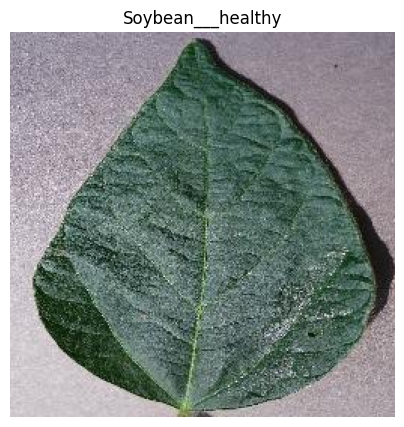

In [ ]:
# Visualizando uma imagem aleatório

img_name = random.choice(train_images)

img_path = os.path.join(images_path, img_name)
label_name = os.path.splitext(img_name)[0] + ".txt"
label_path = os.path.join(labels_path, label_name)

# Ler class_id do label
if os.path.exists(label_path):
    with open(label_path) as f:
        class_id = int(f.readline().strip().split()[0])
    class_name = class_map[class_id]
else:
    class_name = "Unknown"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Mostrar imagem com título da classe
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.title(class_name)
plt.axis('off')
plt.show()

# Desenvolvimento da Arquitetura 1   
## Classificação


In [ ]:
# Criar listas de imagens e labels
all_images = [f for f in os.listdir(images_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

X = []
y = []

for img_name in all_images:
    img_path = os.path.join(images_path, img_name)
    label_name = os.path.splitext(img_name)[0] + ".txt"
    label_path = os.path.join(labels_path, label_name)

    if os.path.exists(label_path):
        with open(label_path) as f:
            class_id = int(f.readline().strip().split()[0])

        #  redimensionar para o modelo e normalizar 0-1
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        img = img / 255.0

        X.append(img)
        y.append(class_id)

In [ ]:
#Treinamento do Modelo
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

In [ ]:
# Avaliação no conjunto de teste
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nAcurácia no teste: {test_acc:.4f}')

# Plot da acurácia e loss durante o treinamento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

# Matriz de confusão e relatório de classificação
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=classes))

In [ ]:
# Otimização com Transfer Learning
# Para melhorar ainda mais o desempenho, podemos usar um modelo pré-treinado:
base_model = keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size, img_size, 3)
)

# Congelar as camadas do modelo base
base_model.trainable = False

# Adicionar novas camadas no topo
inputs = keras.Input(shape=(img_size, img_size, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

transfer_model = keras.Model(inputs, outputs)

transfer_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Treinamento do modelo com transfer learning
history_transfer = transfer_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

# Desenvolvimento da Arquitetura 2
(colocar o nome do tipo de técnica que utilizaremos, ex.: classificação, autoencoder, etc...)


# Avaliação e Validação do Modelo

In [ ]:
# Classificação
# Importações necessárias
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configurações iniciais
plt.style.use('ggplot')
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Tensorflow é uma maneira para compartilhar modelos pré-treinados
# https://www.tensorflow.org/hub?hl=pt-br
# Exemplo para detectar se está andando de patins
#https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/action_recognition_with_tf_hub.ipynb
# Você pode disponibilizar ou usar modelos deste repositório
# !pip install tensorflow_hub --upgrade
import tensorflow_hub as hub


1. Análise Exploratória e Pré-processamento

In [ ]:
class PlantDataAnalyzer:
    """Classe para análise e preparação dos dados do Plant Village"""

    def __init__(self, data_path):
        data_path = "C:/Users/daniela.martino/Downloads/Datasets/PlantVillage_ObjectDetection/PlantVillage_for_object_detection"
        self.data_path = Path(data_path)
        self.class_names = []
        self.class_distribution = {}

    def explore_dataset(self):
        """Explora a estrutura do dataset e suas características"""
        print("=== ANÁLISE EXPLORATÓRIA DO DATASET PLANT VILLAGE ===\n")

        # Coletar informações sobre as classes
        self.class_names = sorted([dir.name for dir in self.data_path.iterdir() if dir.is_dir()])
        print(f"Número de classes: {len(self.class_names)}")
        print(f"Classes: {self.class_names}\n")

        # Analisar distribuição das classes
        print("Distribuição das imagens por classe:")
        total_images = 0
        for class_name in self.class_names:
            class_path = self.data_path / class_name
            num_images = len(list(class_path.glob('*.JPG'))) + len(list(class_path.glob('*.jpg')))
            self.class_distribution[class_name] = num_images
            total_images += num_images
            print(f"{class_name}: {num_images} imagens")

        print(f"\nTotal de imagens no dataset: {total_images}")

        # Plotar distribuição
        self._plot_class_distribution()

        # Mostrar exemplos de imagens
        self._display_sample_images()

        return self.class_distribution

    def _plot_class_distribution(self):
        """Plota a distribuição das classes"""
        plt.figure(figsize=(15, 8))
        plt.bar(range(len(self.class_distribution)), list(self.class_distribution.values()),
                color='lightgreen', edgecolor='darkgreen')
        plt.xlabel('Classes')
        plt.ylabel('Número de Imagens')
        plt.title('Distribuição de Imagens por Classe')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

        # Mostrar estatísticas
        print(f"\nMédia de imagens por classe: {np.mean(list(self.class_distribution.values())):.2f}")
        print(f"Desvio padrão: {np.std(list(self.class_distribution.values())):.2f}")
        print(f"Classe com mais imagens: {max(self.class_distribution, key=self.class_distribution.get)}")
        print(f"Classe com menos imagens: {min(self.class_distribution, key=self.class_distribution.get)}")

    def _display_sample_images(self):
        """Exibe amostras de imagens de cada classe"""
        print("\n=== AMOSTRAS DE IMAGENS ===")

        fig, axes = plt.subplots(5, 7, figsize=(20, 15))
        axes = axes.ravel()

        for i, class_name in enumerate(self.class_names[:35]):  # Mostrar até 35 classes
            class_path = self.data_path / class_name
            img_path = list(class_path.glob('*.JPG')) or list(class_path.glob('*.jpg'))
            if img_path:
                img = cv2.imread(str(img_path[0]))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axes[i].imshow(img)
                axes[i].set_title(class_name, fontsize=10)
                axes[i].axis('off')

        plt.tight_layout()
        plt.show()

    def prepare_data_generators(self, img_size=(224, 224), batch_size=32, validation_split=0.2):
        """
        Prepara os geradores de dados para treinamento
        Utiliza aumento de dados para melhor generalização
        """
        print("\nPreparando geradores de dados com aumento de dados...")

        # Data augmentation para treino
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            validation_split=validation_split,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        # Somente rescale para validação e teste
        test_datagen = ImageDataGenerator(rescale=1./255)

        # Gerador de treino
        train_generator = train_datagen.flow_from_directory(
            self.data_path,
            target_size=img_size,
            batch_size=batch_size,
            class_mode='categorical',
            subset='training',
            shuffle=True
        )

        # Gerador de validação
        validation_generator = train_datagen.flow_from_directory(
            self.data_path,
            target_size=img_size,
            batch_size=batch_size,
            class_mode='categorical',
            subset='validation',
            shuffle=False
        )

        print(f"Classes mapeadas: {train_generator.class_indices}")
        print(f"Número de batches de treino: {train_generator.samples // batch_size}")
        print(f"Número de batches de validação: {validation_generator.samples // batch_size}")

        return train_generator, validation_generator

# Instanciar e analisar os dados
data_path = "plant_village_dataset"  # Ajustar conforme localização do dataset
analyzer = PlantDataAnalyzer(data_path)
class_distribution = analyzer.explore_dataset()
train_gen, val_gen = analyzer.prepare_data_generators(batch_size=32)

2. Arquitetura do Modelo com Transfer Learning

In [ ]:
class PlantDiseaseModel:
    """Classe para construção e treinamento do modelo de deep learning"""

    def __init__(self, num_classes, input_shape=(224, 224, 3)):
        self.num_classes = num_classes
        self.input_shape = input_shape
        self.model = None
        self.history = None

    def build_model(self, base_model_name='EfficientNetB0'):
        """
        Constrói modelo usando transfer learning
        Explicação da arquitetura:
        - Base pre-treinada: Extrai características gerais de imagens
        - Camadas personalizadas: Especializa para o problema específico
        - Regularização: Previne overfitting no dataset menor
        """
        print(f"Construindo modelo com {base_model_name}...")

        # Selecionar modelo base
        if base_model_name == 'EfficientNetB0':
            base_model = applications.EfficientNetB0(
                include_top=False,
                weights='imagenet',
                input_shape=self.input_shape
            )
        elif base_model_name == 'ResNet50':
            base_model = applications.ResNet50(
                include_top=False,
                weights='imagenet',
                input_shape=self.input_shape
            )
        else:
            raise ValueError("Modelo base não suportado")

        # Congelar camadas base inicialmente
        base_model.trainable = False

        # Construir modelo completo
        inputs = tf.keras.Input(shape=self.input_shape)

        # Pré-processamento específico para cada arquitetura
        if base_model_name.startswith('EfficientNet'):
            x = applications.efficientnet.preprocess_input(inputs)
        else:
            x = applications.resnet.preprocess_input(inputs)

        # Passar pela base
        x = base_model(x, training=False)

        # Camadas adicionais
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(512, activation='relu')(x)
        x = layers.Dropout(0.3)(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dropout(0.3)(x)

        # Saída
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)

        self.model = models.Model(inputs, outputs)

        return self.model

    def compile_model(self, learning_rate=0.001):
        """Compila o modelo com otimizador e métricas apropriadas"""
        self.model.compile(
            optimizer=optimizers.Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc')
            ]
        )

        print("Modelo compilado com sucesso!")
        print(f"Learning rate: {learning_rate}")
        self.model.summary()

        return self.model

    def train_model(self, train_generator, validation_generator, epochs=50):
        """Treina o modelo com callbacks para melhor performance"""

        # Callbacks para melhorar o treinamento
        callbacks_list = [
            callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True,
                verbose=1
            ),
            callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-7,
                verbose=1
            ),
            callbacks.ModelCheckpoint(
                'best_plant_model.h5',
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            )
        ]

        print("Iniciando treinamento...")
        self.history = self.model.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator,
            callbacks=callbacks_list,
            verbose=1
        )

        return self.history

    def fine_tune_model(self, train_generator, validation_generator, fine_tune_epochs=20):
        """Realiza fine-tuning nas últimas camadas do modelo base"""
        print("\nIniciando fine-tuning...")

        # Descongelar algumas camadas da base
        self.model.trainable = True

        # Congelar as primeiras camadas e descongelar as últimas
        for layer in self.model.layers[1].layers[:-20]:  # Ajustar conforme a base
            layer.trainable = False

        # Recompilar com learning rate menor
        self.model.compile(
            optimizer=optimizers.Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy', 'precision', 'recall', 'auc']
        )

        # Continuar treinamento
        self.history_finetune = self.model.fit(
            train_generator,
            epochs=len(self.history.epoch) + fine_tune_epochs,
            initial_epoch=len(self.history.epoch),
            validation_data=validation_generator,
            callbacks=[
                callbacks.EarlyStopping(patience=5, restore_best_weights=True),
                callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
            ],
            verbose=1
        )

        return self.history_finetune

    def plot_training_history(self):
        """Plota gráficos do histórico de treinamento"""
        history = self.history.history

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

        # Loss
        ax1.plot(history['loss'], label='Train Loss')
        ax1.plot(history['val_loss'], label='Validation Loss')
        ax1.set_title('Loss durante o Treinamento')
        ax1.legend()

        # Acurácia
        ax2.plot(history['accuracy'], label='Train Accuracy')
        ax2.plot(history['val_accuracy'], label='Validation Accuracy')
        ax2.set_title('Acurácia durante o Treinamento')
        ax2.legend()

        # Precisão e Recall
        ax3.plot(history['precision'], label='Train Precision')
        ax3.plot(history['val_precision'], label='Validation Precision')
        ax3.plot(history['recall'], label='Train Recall')
        ax3.plot(history['val_recall'], label='Validation Recall')
        ax3.set_title('Precisão e Recall')
        ax3.legend()

        # Learning Rate (se disponível)
        if 'lr' in history:
            ax4.plot(history['lr'], label='Learning Rate', color='red')
            ax4.set_title('Taxa de Aprendizado')
            ax4.legend()

        plt.tight_layout()
        plt.show()

# Construir e compilar o modelo
num_classes = len(train_gen.class_indices)
model_builder = PlantDiseaseModel(num_classes=num_classes)
model = model_builder.build_model(base_model_name='EfficientNetB0')
model_builder.compile_model(learning_rate=0.001)

3. Treinamento e Avaliação

In [ ]:
# Treinar o modelo
history = model_builder.train_model(train_gen, val_gen, epochs=30)

# Fine-tuning
history_ft = model_builder.fine_tune_model(train_gen, val_gen, fine_tune_epochs=10)

# Plotar histórico de treinamento
model_builder.plot_training_history()

4. Avaliação e Análise de Resultados

In [ ]:
class ModelEvaluator:
    """Classe para avaliação detalhada do modelo"""

    def __init__(self, model, validation_generator, class_names):
        self.model = model
        self.validation_generator = validation_generator
        self.class_names = class_names

    def evaluate_model(self):
        """Avalia o modelo no conjunto de validação"""
        print("=== AVALIAÇÃO DO MODELO ===")

        # Avaliar métricas
        results = self.model.evaluate(self.validation_generator, verbose=0)
        metrics = dict(zip(self.model.metrics_names, results))

        print(f"Acurácia: {metrics['accuracy']:.4f}")
        print(f"Precisão: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"AUC: {metrics['auc']:.4f}")
        print(f"Loss: {metrics['loss']:.4f}")

        return metrics

    def detailed_classification_report(self):
        """Gera relatório de classificação detalhado"""
        # Prever todas as imagens de validação
        y_pred = self.model.predict(self.validation_generator, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = self.validation_generator.classes

        # Relatório de classificação
        print("\n=== RELATÓRIO DE CLASSIFICAÇÃO ===")
        print(classification_report(y_true, y_pred_classes,
                                  target_names=self.class_names))

        return y_true, y_pred_classes

    def plot_confusion_matrix(self, y_true, y_pred_classes):
        """Plota matriz de confusão"""
        cm = confusion_matrix(y_true, y_pred_classes)

        plt.figure(figsize=(15, 12))
        sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                   xticklabels=self.class_names,
                   yticklabels=self.class_names)
        plt.title('Matriz de Confusão - Classificação de Doenças em Plantas')
        plt.ylabel('Verdadeiro')
        plt.xlabel('Previsto')
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    def plot_sample_predictions(self, num_samples=12):
        """Plota amostras de previsões com labels verdadeiros e previstos"""
        # Obter um batch de dados
        x_batch, y_batch = next(self.validation_generator)
        y_pred = self.model.predict(x_batch, verbose=0)

        # Decodificar labels
        y_true_classes = np.argmax(y_batch, axis=1)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Plotar amostras
        plt.figure(figsize=(15, 10))
        for i in range(num_samples):
            plt.subplot(3, 4, i+1)
            plt.imshow(x_batch[i])

            true_label = self.class_names[y_true_classes[i]]
            pred_label = self.class_names[y_pred_classes[i]]
            confidence = np.max(y_pred[i])

            color = 'green' if true_label == pred_label else 'red'
            plt.title(f'Verd: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}',
                     color=color, fontsize=9)
            plt.axis('off')

        plt.tight_layout()
        plt.show()

# Avaliar o modelo
class_names = list(train_gen.class_indices.keys())
evaluator = ModelEvaluator(model_builder.model, val_gen, class_names)
metrics = evaluator.evaluate_model()
y_true, y_pred = evaluator.detailed_classification_report()
evaluator.plot_confusion_matrix(y_true, y_pred)
evaluator.plot_sample_predictions()

5. Sistema de Predição em Tempo Real

In [ ]:
class PlantDiseasePredictor:
    """Classe para fazer predições em novas imagens"""

    def __init__(self, model, class_names, img_size=(224, 224)):
        self.model = model
        self.class_names = class_names
        self.img_size = img_size

    def preprocess_image(self, image_path):
        """Pré-processa uma imagem para predição"""
        img = tf.keras.preprocessing.image.load_img(
            image_path, target_size=self.img_size
        )
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0  # Normalização

        return img_array

    def predict(self, image_path, top_k=3):
        """Faz predição em uma imagem e retorna as top_k classes"""
        processed_img = self.preprocess_image(image_path)
        predictions = self.model.predict(processed_img, verbose=0)[0]

        # Obter top_k predições
        top_k_indices = np.argsort(predictions)[-top_k:][::-1]
        top_k_classes = [self.class_names[i] for i in top_k_indices]
        top_k_confidences = [predictions[i] for i in top_k_indices]

        return list(zip(top_k_classes, top_k_confidences))

    def predict_and_visualize(self, image_path):
        """Faz predição e visualiza a imagem com resultados"""
        # Fazer predição
        predictions = self.predict(image_path)

        # Carregar e mostrar imagem
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10, 8))
        plt.imshow(img)
        plt.axis('off')

        # Adicionar informações da predição
        prediction_text = "\n".join([f"{cls}: {conf:.2%}" for cls, conf in predictions])
        plt.figtext(0.5, 0.01, f"Predições:\n{prediction_text}",
                   ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

        plt.show()

        return predictions

# Exemplo de uso do predictor
predictor = PlantDiseasePredictor(model_builder.model, class_names)

# Fazer predição em uma nova imagem (substituir pelo caminho real)
# predictions = predictor.predict_and_visualize("path_to_new_plant_image.jpg")

6. Explicação das Soluções Implementadas

Explicação das Soluções Implementadas
1. Complexidade do Problema
O dataset Plant Village possui 38 classes de doenças em 14 espécies de plantas

Desafios: Desbalanceamento de classes, variação nas condições de imagem, similaridade entre algumas doenças

2. Transfer Learning com EfficientNet
Utilizamos EfficientNetB0 como base por seu bom equilíbrio entre acurácia e eficiência computacional

Congelamos as camadas iniciais para aproveitar características genéricas aprendidas no ImageNet

Adicionamos camadas personalizadas para especializar o modelo no domínio de plantas


3. Data Augmentation
Aplicamos transformações robustas para aumentar a diversidade do dataset

Rotações, zoom, deslocamentos e flip horizontal simulam condições reais de captura

4. Fine-tuning Estratégico
Descongelamos apenas as últimas camadas da rede base para especialização

Utilizamos learning rate menor para ajustes refinados sem destruir pesos pre-treinados

5. Métricas de Avaliação Abrangentes
Além da acurácia, avaliamos precisão, recall e AUC para entender melhor o desempenho

A matriz de confusão ajuda a identificar classes problemáticas

6. Sistema de Predição em Tempo Real
Desenvolvemos uma classe dedicada para facilitar a predição em novas imagens

Visualização das predições com confiança para interpretabilidade

Este sistema pode ser integrado em aplicativos móveis para ajudar agricultores a identificar doenças em tempo real,
potencialmente aumentando a produtividade e reduzindo o uso de pesticidas através do diagnóstico precoce e preciso.